# フーリエ・スペクトル法による常微分方程式の周期解の数値計算
$\newcommand{\im}{\mathrm{i}}$
常微分方程式の一つであるvan der Pol方程式の周期解の精度保証付き数値計算を紹介するため、フーリエ・スペクトル法による周期解の数値計算を行う。

## van der Pol 方程式
van der Pol方程式とは、以下のような方程式である。

$$
\frac{d^2 x}{dt^2} - \mu (1-x^2)\frac{dx}{dt} + x = 0.
$$

未知関数は $x(t)$ で、$\mu>0$ は非線形の減衰の強さを表すパラメータである。フーリエ・スペクトル法の計算に必要な参照軌道をまず得るために、van der Pol方程式をJulia言語の`DifferentialEquations.jl`というパッケージを使って解の挙動を数値計算する。

まず、van der Pol 方程式を次の連立常微分方程式系にして`DifferentialEquations.jl`のODEソルバーで数値計算する。

$$
\begin{cases}
\dot{x} = y\\
\dot{y} = \mu (1-x^2)y - x
\end{cases}
$$


In [1]:
versioninfo()

Julia Version 1.7.2
Commit bf53498635 (2022-02-06 15:21 UTC)
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: Intel(R) Core(TM) i9-10900K CPU @ 3.70GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-12.0.1 (ORCJIT, skylake)


In [1]:
using DifferentialEquations

function vanderpol(du, u , μ ,t)
    x,y = u
    du[1] = y
    du[2] = μ*(1- x ^2)*y - x
end

vanderpol (generic function with 1 method)

初期値 $x(0)=0$, $y(0)=2$とし, $\mu=1$ のときの数値計算は以下のように実行される。

In [2]:
u₀ = [0.0; 2.0]
tspan = (0.0, 300)
μ = 1.0
prob = ODEProblem(vanderpol, u₀, tspan, μ)
sol = solve(prob,Tsit5(),reltol=1e-8,abstol=1e-8)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 6121-element Vector{Float64}:
   0.0
   0.009232541136674264
   0.02503848692409142
   0.04358791409289996
   0.066445221117261
   0.09233090171528248
   0.1213988849663063
   0.15277986388185555
   0.18598700743093166
   0.22027027615414818
   0.25511905189622813
   0.29011573040812205
   0.32502612741236214
   ⋮
 299.3910669858661
 299.468286719703
 299.54077980109815
 299.608751435346
 299.6728452047304
 299.73339076290443
 299.7906647064316
 299.84478473855
 299.8961891979806
 299.94617943395525
 299.9938352351482
 300.0
u: 6121-element Vector{Vector{Float64}}:
 [0.0, 2.0]
 [0.01855031657580365, 2.0184626866340247]
 [0.050703595436878524, 2.050027988176535]
 [0.08907287465040681, 2.086909821404441]
 [0.13728952243153142, 2.1319144155808947]
 [0.19312565278980298, 2.1819383562142463]
 [0.2573461944267867, 2.236335516474371]
 [0.3284087346554558, 2.2920864005994797]
 [0.4054411340434457, 2.346530010799726]


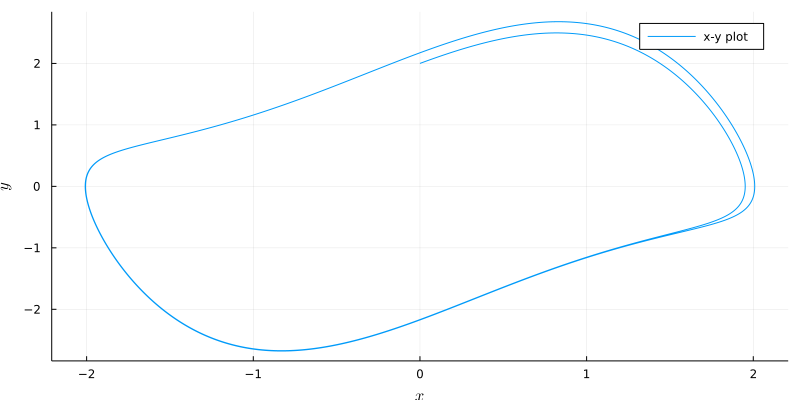

In [10]:
using Plots
plot(sol, vars=(1,2), size=(800,400), label="x-y plot", xlabel="\$x\$", ylabel="\$y\$")

In [3]:
u = hcat(sol.u...)

2×6121 Matrix{Float64}:
 0.0  0.0185503  0.0507036  0.0890729  …  0.318023  0.437247  0.452953
 2.0  2.01846    2.05003    2.08691       2.45866   2.54276   2.55261

数値計算で得た結果、ある程度の時間が過ぎると下図のような周期軌道（に近い解の軌道）が現れる。

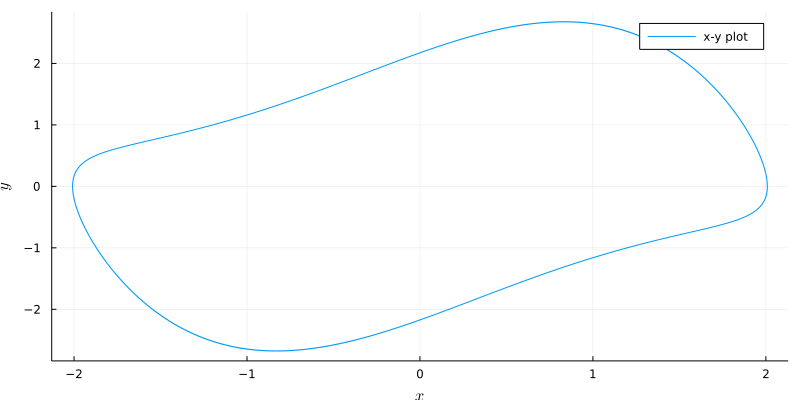

In [6]:
ind = floor(Int, length(sol.t)/2)
plot(u[1, ind:end], u[2, ind:end], size=(800,400), label="x-y plot", xlabel="\$x\$", ylabel="\$y\$")

## Newton法の初期値の設定

周期解をフーリエ級数で現わし、その係数と周期を求めるため、van der Pol方程式の周期解の周期を大まかに求める。

In [4]:
#おおよその周期
a = 30
app_period = 6.55
timestep = 0.1

f_tmp = sol(a+app_period/2:timestep:a+3*app_period/2)
find_period = abs.(f_tmp .- sol(a))
(~,ind) = findmin(find_period[1,:])
b = a+app_period/2 + timestep*(ind-1)
# abs.(sol(b) .- sol(a))

36.675

得た近似周期軌道と近似周期を使って、軌道のフーリエ補間を計算する。詳細は[フーリエ級数](https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/Fourier_series.html)を参照。

In [5]:
#a function of  fourier coeffs
using FFTW
function odefouriercoeffs(f, N, I, n=1)
    a = I[1]; b = I[2];
    # x_j: equidistance node points
    h = (b-a)/(2N-1)
    j = 0:2N-2
    xⱼ = a .+ j*h
    # f_j: function values on node points
    fⱼ = f(xⱼ)[n,:]
    return (fftshift(fft(fⱼ)))/(2*N-1)
end

odefouriercoeffs (generic function with 2 methods)

In [6]:
# compute Fourier fouriercoeffs
N = 61 # size of Fourier
a₀ = odefouriercoeffs(sol,N,[a,b])

121-element Vector{ComplexF64}:
 0.00010857243174328273 + 1.447313748733519e-6im
 0.00010856849261620066 + 4.343718754746062e-6im
 0.00010856075337722146 + 7.246219053859312e-6im
 0.00010854882863007258 + 1.015838143450129e-5im
 0.00010853325180065536 + 1.3084515275039563e-5im
 0.00010851317536591029 + 1.602854385877283e-5im
 0.00010848929273195426 + 1.8994569469712845e-5im
 0.00010846070937811934 + 2.1987128095905968e-5im
 0.00010842777510930116 + 2.5010377581745834e-5im
 0.00010839007058015676 + 2.806926217030905e-5im
 0.00010834734654050472 + 3.116838879455547e-5im
 0.00010829961187479309 + 3.431296726139727e-5im
 0.00010824619538051401 + 3.75082237212394e-5im
                        ⋮
 0.00010829961187479249 - 3.431296726139757e-5im
 0.00010834734654050397 - 3.116838879455553e-5im
 0.00010839007058015663 - 2.8069262170308935e-5im
 0.00010842777510930733 - 2.5010377581745956e-5im
 0.00010846070937811943 - 2.19871280959061e-5im
 0.00010848929273195662 - 1.899456946979492e-5im
 0.0001

In [11]:
function plot_solution(u, index) # u = [ω, a_{-N+1}, ..., a_0, ..., a_{N-1}], length(u) = 2N
    # index = 1: profile of solution
    #         2: Fourier mode
    #         3: phase profile
    ω = real(u[1])
    L = 2π / ω
    a = u[2:end]
    N = length(u)/2 # N: size of Fourier
    n_pad =1000
    a_pad = [zeros(n_pad);a;zeros(n_pad)]
    N_pad = N + n_pad    
    dx = L/(2*N_pad-1)
    x = dx*(0:2*N_pad-2)
    if index == 1
    # Plot profile:
        plot(x,real((2N_pad-1)*ifft(ifftshift(a_pad))),
            xlabel = "\$t\$",
            ylabel = "\$x\\,(t)\$",
            line   = 1.6,
            title  = "Profile of the solution",
            size   = (800,400),
            legend = false,
        )
    elseif index == 2
    # Plot Fourier coefficients:
        plot((-N+1):(N-1),abs.(a),yscale=:log10,
            xlabel = "\$k\$",
            ylabel = "\$|a_k\\,|\$",
            line   = 1.6,
            title  = "Fourier coefficients of the solution",
            size   = (800,400),
            legend = false,
        )
    elseif index == 3
    # Plot phase:
      k = (-N_pad+1):(N_pad-1)
      plot(real((2N_pad-1)*ifft(ifftshift(a_pad))),real((2N_pad-1)*ifft(ifftshift(a_pad.*(im*k*ω)))),
            xlabel = "\$x(t)\$",
            ylabel = "\$\\dot{x}\\,(t)\$",
            line   = 1.6,
            title  = "Phase plot of a numerical solution",
            size   = (800,400),
            legend = false,
        )
    end
end
function plot_solution!(u)
    L = 2π/real(u[1])
    a = u[2:end]
    N = length(u)/2
    n_pad = 1000
    a_pad = [zeros(n_pad);a;zeros(n_pad)]
    N_pad = N+n_pad
    k = (-N_pad+1):(N_pad-1)
    dx = L/(2*N_pad-1)
    x = dx*(0:2*N_pad-2)
    plot!(real((2N_pad-1)*ifft(ifftshift(a_pad))), real((2N_pad-1)*ifft(ifftshift(a_pad.*(im*k)))),
        line=1.6,
        label="Fourier interpolation"
    )
end

plot_solution! (generic function with 1 method)

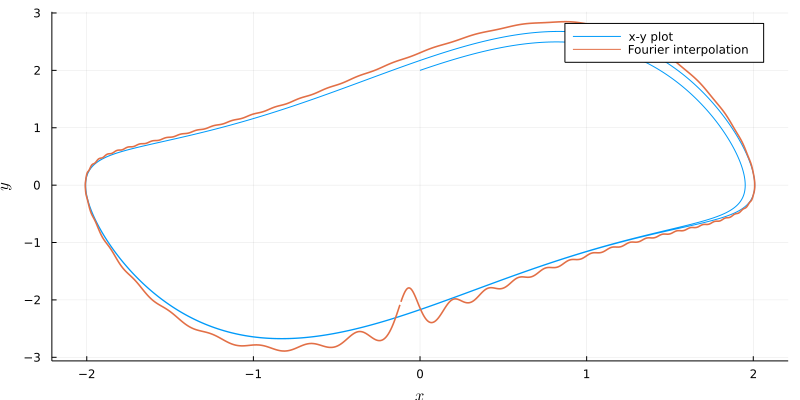

In [12]:
x0 = [2*pi/(b-a);a₀]
plot_solution!(x0)

## Newton法を用いた周期解の計算

van der Pol方程式は、$\dot{x} = \frac{dx}{dt}$ とおくと、以下のように表すことができる。

$$
\ddot{x} - \mu(1-x^2)\dot{x} + x = 0.
$$


あとの計算のために、式を整理すると、

$$
\ddot{x} - \mu\dot{x} + \frac{\mu}{3} \dot{(x^3)} + x = 0.
$$

周期解 $x(t)$ を周期 $L$ の周期関数とし、$\omega = \frac{2\pi}{L}$ とおくと、$x(t)$ とその微分やべき乗はフーリエ級数を使って、

$$
\begin{align*}
x(t) &= \sum_{k \in \mathbb{Z}} a_k e^{\im k\omega t}\\
\frac{dx(t)}{dt} &= \sum_{k \in \mathbb{Z}}(\im k \omega) a_k e^{\im k \omega t} \\
\frac{d^2 x(t)}{dt^2} &= \sum_{k \in \mathbb{Z}} (-  k^2 \omega^2 )a_k e^{\im k\omega t} \\
x(t)^3 &= \sum_{k \in \mathbb{Z}} (a * a * a)_k e^{\im k \omega t}
\end{align*}
$$

と書くことができる。ここで

$$
(a * a * a)_k := \sum_{\substack{k_1+k_2+k_3 = k\\k_i\in\mathbb{Z}}} a_{k_1}a_{k_2}
a_{k_3},\quad k\in\mathbb{Z}
$$

は3次の離散たたみこみである。



$\newcommand{\bx}{\mathrm x}$


そしてフーリエ係数に関する式を立てる。係数 $a = (a_k)_{k \in \mathbb{Z}}$ に対して、van der Pol方程式に求めたフーリエ級数を代入すると、

$$
    f_k(a) := -k^2\omega^2 a_k - \mu\im k \omega a_k + \frac{\mu }{3}(\im k \omega)(a*a*a)_k + a_k
$$

となる点列 $\left(f_k(a)\right)_{k\in\mathbb{Z}}$がえられる。そして、各 $k\in\mathbb{Z}$ について

$$
f_k(a) = 0
$$

となる点列 $a$ が得られれば、van der Pol方程式の解のフーリエ係数になる。未知数は周波数 $\omega$ と点列 $a$ であり、これらを並べて $\bx = (\omega,a)$ と書くことにする。未知数 $\bx$ に対して、$f_k(a) = 0$ という方程式だけでは不定な方程式になるため、解の形を一つに定める事ができない（並進対称性がある）。そこで、位相条件

$$
\begin{align*}
    \eta (a) &:= \sum_{|k|<N} a_k - \eta_0=0, \quad \eta_0 \in \mathbb{R}
\end{align*}
$$

を加える。この条件は $x(t)$ の切片 $x(0) = \eta_0$ を表している。最終的に van der Pol 方程式の周期解の求解は次の代数方程式を解くことに帰着される。

$$
    F(\bx) := 
    \begin{bmatrix}
    \eta (a) \\
    (f_k(a)_{k\in\mathbb{Z}}
    \end{bmatrix}
    =0.
$$

以下、この零点探索問題 $F(\bx)=0$ について Newton 法で解を得ることを考える。まず $N$ をフーリエ係数の打ち切り番号（最大波数:$N-1$）とし、周期解の近似を次のように構成する。

$$
 \bar{x}(t) = \sum_{|k|<N} \bar{a}_k e^{\im k \bar\omega t}.
$$

このとき、フーリエ係数と（近似）周期をならべた

$$
    \bar{\bx} = (\bar\omega, \bar{a}_{-N+1},\dots,\bar{a}_{N-1})\in \mathbb{C}^{2N}
$$

を近似解とよぶ。近似解 $\bar \bx$ の項数は $2N$ 個。そして $f_k(a)=0$ を $|k|<N$ の範囲で打ち切る方程式

$$
    F^{(N)}(\bx^{(N)}) = 
    \begin{bmatrix}
    \eta (a^{(N)}) \\
    (f_k(a^{(N)}))_{k < |N|}
    \end{bmatrix}
    =0
$$

を考える。ここで $a^{(N)} = (a_k)_{|k|<N}$, $\bx^{(N)} = (\omega,a^{(N)})$ をそれぞれ表し、$F^{(N)}:\mathbb{C}^{2N}\to \mathbb{C}^{2N}$ である。したがって $F^{(N)}(\bx^{(N)}) = 0$ という有限次元の非線形方程式を解くことで、近似解 $\bar \bx$ が得られる。



### Newton法による周期解の数値計算

実際にNewton法を用いて、周期解の数値計算を行っていく。Newton法では、ある適当な初期値 $\bx_0$ を最初に定め、以下の反復計算によって計算できる。

$$
    \bx_{n+1} = \bx_n - DF^{(N)}(\bx_n)^{-1} F^{(N)}(\bx_n),\quad n=0,1,\dots
$$

このことから $DF^{(N)}(\bx_n)^{-1}$ と $F^{(N)}(\bx_n)$ を計算することができれば、近似解を得ることができる。はじめに離散畳み込みの関数`powerconvfourier`を用意する。詳細は[離散畳み込みの精度保証](https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/discrete_convolution.html)を参照。

In [13]:
function powerconvfourier(a::Vector{Complex{T}},p) where T
    M = Int((length(a)+1)/2)
    N = (p-1)*M
    ta = [zeros(N,1);a;zeros(N,1)] # 1. Padding zeros: size(ta) = 2pM-1
    tb = ifft(ifftshift(ta)) # 2. IFFT of ta
    tbᵖ = tb.^p # 3. tb*^tb
    cᵖ = fftshift(fft(tbᵖ))*(2.0*p*M-1)^(p-1)
    return cᵖ[N+1:end-N], cᵖ[p:end-(p-1)]# return (truncated, full) version
end

powerconvfourier (generic function with 1 method)

次の`F_fourier`は $F^{(N)}(\bx_n)$ を計算している。

In [14]:
function F_fourier(x, μ, η₀)
    N = length(x)/2
    ω = x[1]
    a = x[2:end]
    (a³,~) = powerconvfourier(a,3)
    eta = sum(a) - η₀

    k = -(N-1):(N-1)
    f = (- k.^2 * ω^2 - μ* im * k * ω .+ 1) .* a + μ*im * k *ω .* a³ / 3

    return [eta;f]
end

F_fourier (generic function with 1 method)

### ヤコビ行列の計算式

$F^{(N)}(\bx^{(N)})$のヤコビ行列は、

$$
    DF^{(N)}(\bx^{(N)}) =
    \left[\begin{array}{c|ccc}
    0 & 1 & \dots & 1\\\hline
    \vdots & &\vdots&\\
    \partial_{\omega}f_k& \dots & \partial_{a_j}f_k & \dots\\
    \vdots & &\vdots& 
    \end{array}\right]\in\mathbb{C}^{2N\times 2N}\quad (|k|,|j|<N).
$$

ここで、

$$
    \begin{cases}
    \partial_\omega f_k = (-2k^2 \omega - \mu \im k) a_k + \frac{\mu \im k}{3}(a*a*a)_k & (|k|<N)\\
    \partial_{a_j} f_k = (-k^2 \omega^2 - \mu \im k \omega + 1) \delta_{kj} + \mu \im k \omega (a*a)_{k-j}&(|k|,|j|<N)
    \end{cases},\quad \delta_{kj} = \begin{cases} 1 & (k=j)\\ 0 & (k\neq j)
    \end{cases}
$$

である。ヤコビ行列の各要素との対応は

$$
\left(DF^{(N)}(\bx^{(N)})\right)_{\ell,m} = 
\begin{cases}
0 \ &(\ell=m=1) \\
1 \ &(\ell=1, m = 2 \cdots 2N) \\
\partial_\omega f_k &(\ell = 2 \cdots 2N, m = 1,~\mbox{i.e.},~\ell = k + N + 1~\mbox{for}~|k|<N)\\
\partial_{a_j} f_k &(\ell,m = 2 \cdots 2N,~\mbox{i.e.},~\ell = k + N + 1~\mbox{for}~|k|<N,~m = j + N + 1~\mbox{for}~|j|<N).
\end{cases}
$$


In [15]:
function DF_fourier(x, μ)
    N = Int((length(x))/2)
    ω = x[1]
    a = x[2:end]
    k = (-N+1):(N-1)
    (a³,~) = powerconvfourier(a,3)

    DF = zeros(ComplexF64,2N,2N)

    DF[1,2:end] .= 1
    DF[2:end,1] = (- 2*ω*k.^2 - μ*im*k) .* a + μ*im*k .*a³/3

    (~,a2) = powerconvfourier(a,2)
    
    M = zeros(ComplexF64,2*N-1, 2*N-1)

    for j=(-N+1):(N-1)
        M[k.+N, j+N] = μ*im*k*ω.*a2[k.-j.+(2*N-1)]
    end
    
    L = diagm(- k.^2 * ω^2 - μ* im * k * ω .+ 1)
    
    DF[2:end,2:end] = L + M
    return DF
end

DF_fourier (generic function with 1 method)

### Newton法の反復

Newton法の反復を以下のコードで実行する。

Before step #1, ||F||_1 = 17.12970698527179
After step #1, ||F||_1 = 0.16249057553472976
After step #2, ||F||_1 = 0.000948290973035295
After step #3, ||F||_1 = 1.9840283082628562e-8
After step #4, ||F||_1 = 1.6160979408768862e-13
L = (2π) / real(x[1]) = 6.66328685932313


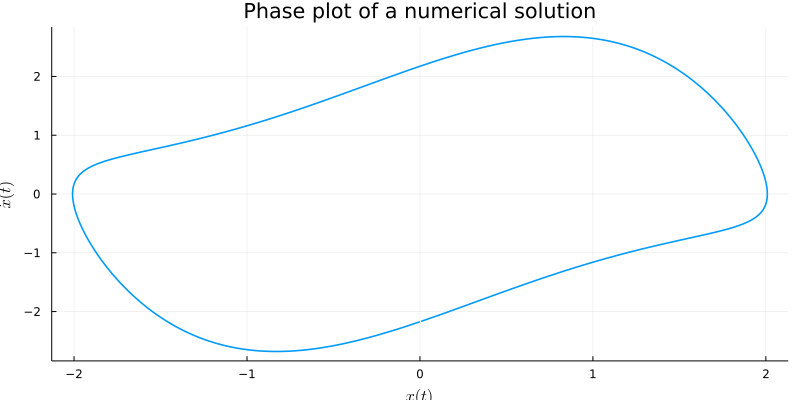

In [16]:
using LinearAlgebra
# Initial value of Newton method
# η₀ = real(sum(x0[2:end]))
η₀ = 0
x = x0

# Newton iteration
tol = 5e-10
F = F_fourier(x, μ, η₀)
println("Before step #1, ||F||_1 = $(norm(F,1))")
num_itr = 0

while num_itr ≤ 100
    x = x - DF_fourier(x, μ)\F
    num_itr += 1
    F = F_fourier(x, μ, η₀)
    println("After step #$(num_itr), ||F||_1 = $(norm(F,1))")
    if norm(F,1) < tol
        break
    end
end

@show L = 2π/real(x[1])
plot_solution(x, 3)
# plot!(u[1, ind:end], u[2, ind:end], legend=false)

Newton法の3回の反復でJuliaの`DifferentialEquations.jl`で計算した軌道を初期値からvan der Pol方程式の近似周期軌道を得ることに成功した。この軌道のプロファイル、フーリエ係数の情報は以下で確認できる。

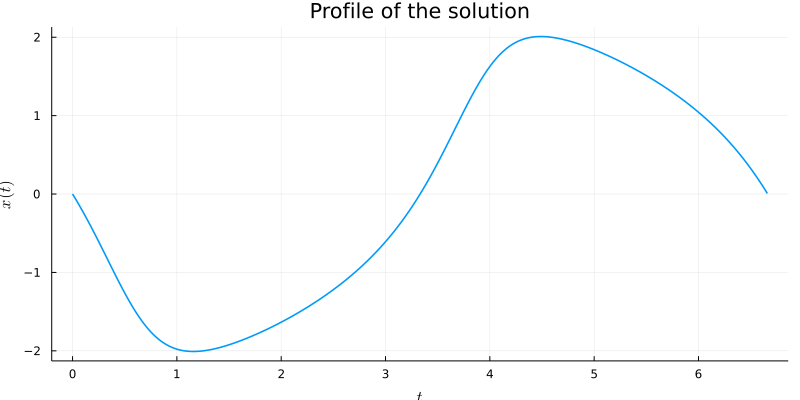

In [16]:
plot_solution(x, 1)

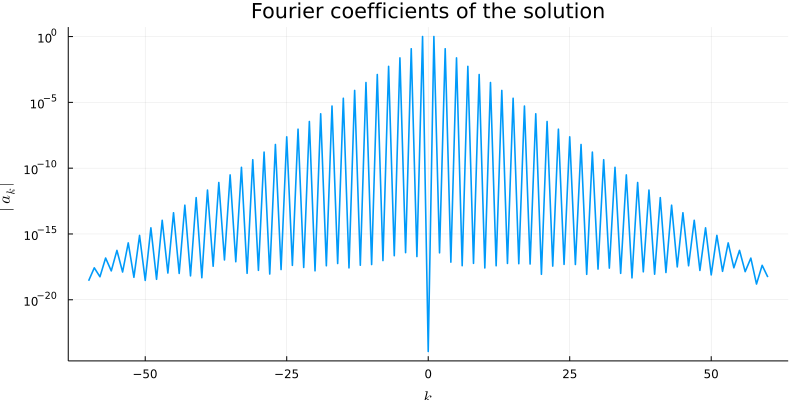

In [17]:
plot_solution(x, 2)

本資料は以下のような文献・Web ページ等を参考に書いています。

### 参考文献

1. DifferentialEquations.jl: Scientific Machine Learning (SciML) Enabled Simulation and Estimation (https://diffeq.sciml.ai/stable/).<br>
(Julia言語のDifferentialEquations.jlのマニュアル。今回取り上げた常微分方程式だけでなく、遅延微分方程式、偏微分方程式、微分代数方程式の解法なども実装されている。)
1. Jan Bouwe van den Berg, Jean-Philippe Lessard, Proceedings of Symposia in Applied Mathematics 74, American Mathematical Society, 2018.<br>
(力学系におけるNewton-Kantorovich型定理を使った精度保証付き数値計算の教科書、フーリエ級数・チェビシェフ級数の畳み込みを使った実践例をいくつか紹介している)
1. 高橋和暉, 高安亮紀, [フーリエ級数](https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/Fourier_series.html), 2022.<br>
（FFTを利用したフーリエ補間の計算方法をJuliaで実装する例を紹介している）
1. 高橋和暉, 高安亮紀, [離散畳み込みの精度保証](https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/discrete_convolution.html), 2022.<br>
（FFTを利用した離散畳み込みの計算方法とその精度保証付き数値計算方法をJuliaで実装する例を紹介している）

<div align="right">高橋和暉, <a href="http://www.risk.tsukuba.ac.jp/~takitoshi/">高安亮紀</a>，2022年3月7日</div>